In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case4'
model_name = 'case4_modflow'
model_ws = './models_folder/' + data_folder

Lx = 0.08
Ly = 1.0

nrow = 1
ncol = 40
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

top = 1.0
botm = 0.0

hk = 1.0

nper = 1
perlen = [20736,]
nstp = [120,]
steady = [True,]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc, top=top, botm=botm,
                              nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=1, ipakcb=53)

chd_data = {0: [[0, 0, ncol-1, 1.0, 1.0],]}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_data)

wel_data = {0: [[0, 0, 0, 1.15741E-05]]} # [0, 0, 40, 0.1]
wel = flopy.modflow.ModflowWel(model, ipakcb=66, stress_period_data=wel_data, unitnumber=78)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data, compact=True)

pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


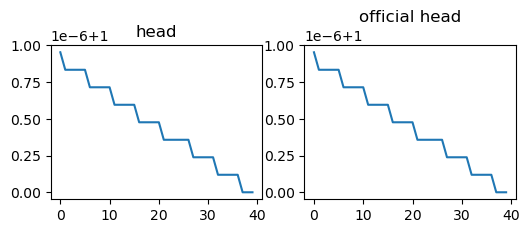

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex04_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=0,
    ph_ph=0,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)
# spec

'./models_folder/case4\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

for i in range(1):
    for key in spec.keys():
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['ca'] = 0.0006
    wel_spec['cl'] = 0.0012
    wel_spec['k'] = 0.0
    wel_spec['na'] = 0.0
    wel_spec['n5'] = 0.0

    wel_spec['ph'] = 6.997
    wel_spec['pe'] = 13.63

    wel_spec['cax2'] = 0.0
    wel_spec['nax'] = 0.0
    wel_spec['kx'] = 0.0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  0,
  0,
  0.0,
  2,
  0.0006,
  0.0012,
  0.0,
  0.0,
  0.0,
  6.997,
  13.63,
  0.0,
  0.0,
  0.0]}

In [6]:
model_name = 'case4_mt3dms'
icbund = np.abs(ibound)

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 1.0

save_times = [0, 172.8, 345.6, 518.4, 691.2, 864, 1036.8, 1209.6, 1382.4, 1555.2, 1728, 1900.8, 2073.6, 2246.4, 2419.2, 2592, 2764.8, 2937.6, 3110.4, 3283.2, 3456, 3628.8, 3801.6, 3974.4, 4147.2, 4320, 4492.8, 4665.6, 4838.4, 5011.2, 5184, 5356.8, 5529.6, 5702.4, 5875.2, 6048, 6220.8, 6393.6, 6566.4, 6739.2, 6912, 7084.8, 7257.6, 7430.4, 7603.2, 7776, 7948.8, 8121.6, 8294.4, 8467.2, 8640, 8812.8, 8985.6, 9158.4, 9331.2, 9504, 9676.8, 9849.6, 10022.4, 10195.2, 10368, 10540.8, 10713.6, 10886.4, 11059.2, 11232, 11404.8, 11577.6, 11750.4, 11923.2, 12096, 12268.8, 12441.6, 12614.4, 12787.2, 12960, 13132.8, 13305.6, 13478.4, 13651.2, 13824, 13996.8, 14169.6, 14342.4, 14515.2, 14688, 14860.8, 15033.6, 15206.4, 15379.2, 15552, 15724.8, 15897.6, 16070.4, 16243.2, 16416, 16588.8, 16761.6, 16934.4, 17107.2, 17280, 17452.8, 17625.6, 17798.4, 17971.2, 18144, 18316.8, 18489.6, 18662.4, 18835.2, 19008, 19180.8, 19353.6, 19526.4, 19699.2, 19872, 20044.8, 20217.6, 20390.4, 20563.2, 20736]
## Define FloPy packages
exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=1, mxstrn=50000, tsmult=1, timprs=save_times, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75, mxpart=100000, nadvfd=2)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.002, trpt=0.1, trpv=0.1, multiDiff=True,dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=1, cclose=1.e-8)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5
DSP: setting dmcoef for component 6 to zero, kwarg name dmcoef6
DSP: setting dmcoef for component 7 to zero, kwarg name dmcoef7


In [7]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [8]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    172.80    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:   129.6     Total Elapsed Time:   129.60    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3649      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8777E-01  [K,I,J]    1    1    2
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2654E-01  [K,I,J]    1    1    3
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8964E-02  [K,I,J]    1    1    4
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2980E-02  [K,I,J]    1    1    5
 Outer Iter.  1  Inner Iter.  6:  Max

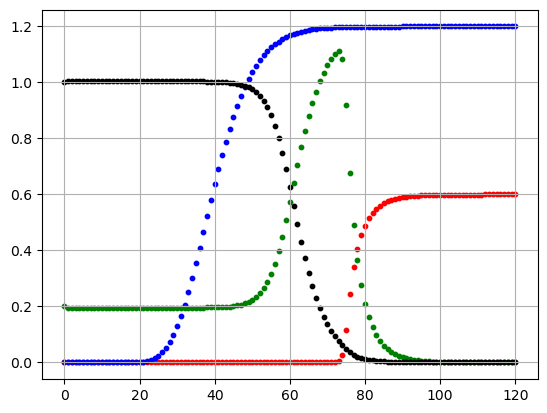

In [9]:
results_ca = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D001.UCN').get_alldata()
results_cl = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D002.UCN').get_alldata()
results_k = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D003.UCN').get_alldata()
results_na = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D004.UCN').get_alldata()

plt.scatter(np.arange(121), results_ca[:,0,0,39]*1000, s=10.0, color='red', label='Ca')
plt.scatter(np.arange(121), results_cl[:,0,0,39]*1000, s=10.0, color='blue', label='Cl')
plt.scatter(np.arange(121), results_k[:,0,0,39]*1000, s=10.0, color='green', label='K')
plt.scatter(np.arange(121), results_na[:,0,0,39]*1000, s=10.0, color='black', label='Na')
plt.legend
plt.grid()